In [1]:
# Load project functions
import crypto_monetary_base as cmb

In [2]:
import datetime
import math

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import gauss
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [3]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn, tqdm

Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 2 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
tqdm 4.55.1
Mon Feb 15 19:48:26 2021 EST

## Supply Curve Calculation

In [4]:
COIN_SYMBOL = 'FIL'

# See https://filecoin.io/blog/filecoin-circulating-supply/
TOTAL_MINTING = 1_100_000_000

# Display ticks
OUTPUT_GRANULARITY = 10000

## See https://spec.filecoin.io/#section-systems.filecoin_token.block_reward_minting
# Epoch is 30 sec
EPOCH_SECS = 30
SECS_PER_YEAR = 365*24*60*60
EPOCH_PER_YEAR = SECS_PER_YEAR/EPOCH_SECS

# Lambda specifies the half-life of the issuance exponential decay function:
# this sets lambda such that the half life is six years (wrt no. of epochs)

# lambda = ln(2) / (6 * epochsInYear)
LAMBDA = math.log(2)/(6*EPOCH_PER_YEAR)

# Initial params
# See https://spec.filecoin.io/#section-algorithms.cryptoecon.initial-parameter-recommendation

# baseline initial value = 2.5057116798121726 EiB
BASELINE_INITIAL_VALUE = 2_888_888_880_000_000_000

# baseline annual growth rate = 100%
BASELINE_ANNUAL_G = 1

# used in the equation to calculate effective network time
# wrt epoch (which is what E.N.T. is denominated in)
BASELINE_G = math.log(1 + BASELINE_ANNUAL_G)/EPOCH_PER_YEAR

# Simulate evolution in effective network time as a Gaussian random walk with these params.
INITIAL_POWER = BASELINE_INITIAL_VALUE * 0.2 # Start at 20% of target (~500 PiB)
GAUSSIAN_ANNUAL_G = 0.5 * BASELINE_ANNUAL_G # % of target growth each year
GAUSSIAN_GRANULARITY = OUTPUT_GRANULARITY # adjust once per display tick (~3 days)
GAUSSIAN_MEAN = math.log(1 + GAUSSIAN_ANNUAL_G)*GAUSSIAN_GRANULARITY/EPOCH_PER_YEAR
GAUSSIAN_STDEV = 0.68 * GAUSSIAN_MEAN # normal distribution

# γ is the mixture between baseline and simple minting.
# A γ value of 1.0 corresponds to pure baseline minting,
# while a γ value of 0.0 corresponds to pure simple minting.
GAMMA_INITIAL = 0.7

# move gamma by GAMMA_ADJUST every GAMMA_GRANULARITY epochs
GAMMA_GRANULARITY = EPOCH_PER_YEAR

# increase to 1.0 over 50 years
GAMMA_ADJUST = (1-GAMMA_INITIAL)/50

In [5]:
# Recalculate breakdown between simple and baseline as gamma changes
def compute_simple_total(gamma):
    return TOTAL_MINTING * (1-gamma)

def compute_baseline_total(gamma):
    return TOTAL_MINTING * gamma

# Effective network time is a function of initial baseline, baseline growth, and
# realized cumsum (cumulative capped raw-byte power, i.e., realized spacetime, bytes x epochs).
def compute_effective_network_time(cumsumRealized):
    return (1/BASELINE_G)*math.log((BASELINE_G*cumsumRealized/BASELINE_INITIAL_VALUE)+1)

# Baseline supply at effective network time theta
def compute_baseline_supply(theta, gamma):
    return compute_baseline_total(gamma) * (1 - (math.exp(-1 * theta * LAMBDA)))

def compute_simple_supply(epoch, gamma):
    return compute_simple_total(gamma) * (1 - math.exp(-1 * epoch * LAMBDA))

In [6]:
def fil_supply_curve(num_epochs):
    out = [
        # Block num,
        # y_1: Simple supply,
        # y_2: Baseline supply,
        # y_3
        # y_4
        # y_5
    ]
    y_1 = 0
    y_2 = 0
    y_3 = 0
    y_4 = 0
    y_5 = 0
    epoch = 0
    currPower = INITIAL_POWER
    cumsumRealized = 0
    gamma = GAMMA_INITIAL
    for epoch in tqdm(range(1, num_epochs+1)):
        epoch += 1
        if gamma > 0 and gamma < 1 and (epoch-1) % GAMMA_GRANULARITY == 0:
            gamma = gamma + GAMMA_ADJUST

        if (epoch-1) % OUTPUT_GRANULARITY == 0:
            ## FIXED GAMMA, MAX ENT
            
            # simple supply
            y_1 = compute_simple_supply(epoch, GAMMA_INITIAL)
            
            # baseline supply (assume max. E.N.T., theta == epoch)
            y_2 = compute_baseline_supply(epoch, GAMMA_INITIAL)

            ## FIXED GAMMA, RANDOM ENT
            theta = min(compute_effective_network_time(cumsumRealized), epoch)
            y_3 = compute_baseline_supply(theta, GAMMA_INITIAL)
            
            # Model effective network time using a Gaussian random walk
            currPower *= (1+gauss(GAUSSIAN_MEAN, GAUSSIAN_STDEV))
            cumsumRealized += currPower * OUTPUT_GRANULARITY # add spacetime (bytes x epochs)

            ## MOVING GAMMA, MAX ENT

            # Calculating supply when gamma is moving is trickier since incremental supply can turn
            # negative or exceed total minting. To prevent this, we never let supply decline or
            # exceed this amount.

            # simple supply
            y_4 = min(max(compute_simple_supply(epoch, gamma), y_3), TOTAL_MINTING - y_5)

            # baseline supply (assume max. E.N.T., theta == epoch)
            y_5 = min(max(compute_baseline_supply(epoch, gamma), y_4), TOTAL_MINTING - y_4)
            
            out.append([epoch, gamma, theta, currPower, cumsumRealized, y_1, y_2, y_3, y_4, y_5])
            
    return out

In [7]:
def datetime_fil_supply_curve(
    start_date,
    epoch_time,
    supply,
    output_granularity=10000,
    ):
    df = pd.DataFrame(
        supply, columns=['epoch', 'gamma', 'theta', 'curr_power', 'cumsum_realized', 'simple_fixed', 'baseline_fixed', 'baseline_fixed_walk', 'simple_moving', 'baseline_moving']
    )
    df['simple_fixed_pct'] = (
        df['simple_fixed'] / df['simple_fixed'].values[-1]
        * 100
    )
    df['baseline_fixed_pct'] = (
        df['baseline_fixed'] / df['baseline_fixed'].values[-1]
        * 100
    )
    df['baseline_fixed_walk_pct'] = (
        df['baseline_fixed_walk'] / df['baseline_fixed_walk'].values[-1]
        * 100
    )
    df['simple_moving_pct'] = (
        df['simple_moving'] / df['simple_moving'].values[-1]
        * 100
    )
    df['baseline_moving_pct'] = (
        df['baseline_moving'] / df['baseline_moving'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=epoch_time * output_granularity,
        periods=len(df)
    )
    return df

In [17]:
def plot_fil_supply_curve_simple(
    supply,
    coin_name=COIN_SYMBOL,
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    
    # Set up the plot
    fig, ax1 = plt.subplots()
#     fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.set_xlabel('date')
    ax1.set_ylabel('issuance')
    
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    ## TOTAL
    values = supply.simple_fixed.values[::step_size]+supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total',
    )
    
    ## FIXED GAMMA
    
    # Simple
    if plot_pct:
        values = supply.simple_fixed_pct.values[::step_size]
    else:
        values = supply.simple_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='simple',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_fixed_pct.values[::step_size]
    else:
        values = supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline',
    )
    
    ## Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.simple_fixed_pct]
    else:
        values = [current_supply.simple_fixed]
    ax1.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    ax1.legend()
    
    if plot_pct:
        ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}_simple.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [45]:
def plot_fil_supply_curve_complex1(
    supply,
    coin_name=COIN_SYMBOL,
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    
    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(9.6, 7.2))
#     color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('issuance')
    
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    ## FIXED GAMMA

    # Total
    values = supply.simple_fixed.values[::step_size]+supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total-fixed',
#         color='red',
    )
    
    # Simple
    if plot_pct:
        values = supply.simple_fixed_pct.values[::step_size]
    else:
        values = supply.simple_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='simple-fixed',
#         color='green',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_fixed_pct.values[::step_size]
    else:
        values = supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline-fixed',
#         color='orange',
    )
    
    ## MOVING GAMMA

    # Total
    values = supply.simple_moving.values[::step_size]+supply.baseline_moving.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total-moving',
#         color='red',
    )
    
    # Simple
    if plot_pct:
        values = supply.simple_moving_pct.values[::step_size]
    else:
        values = supply.simple_moving.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='simple-moving',
#         color='yellow',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_moving_pct.values[::step_size]
    else:
        values = supply.baseline_moving.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline-moving',
#         color='purple',
    )
    
    ## Plot gamma (separate y axis as different scale)
    ax2 = ax1.twinx()
#     color = 'tab:blue'
    ax2.set_ylabel('gamma')
    values = supply.gamma.values[::step_size]
    ax2.plot_date(
        dates,
        values,
        fmt='.',
        lw=4,
        label='gamma',
        color='black',
    )
    ax2.legend(loc='lower right')
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    ax1.legend(loc='upper left')
    
    if plot_pct:
        ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}_complex1.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [48]:
def plot_fil_supply_curve_complex2(
    supply,
    coin_name=COIN_SYMBOL,
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    
    # Set up the plot
#     fig, ax1 = plt.subplots(figsize=(20, 10))
    fig, ax1 = plt.subplots()
#     color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('issuance')
    
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    ## FIXED THETA
    
    # Total
    values = supply.simple_fixed.values[::step_size]+supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total-fixed',
#         color='red',
    )
    
    # Simple
    if plot_pct:
        values = supply.simple_fixed_pct.values[::step_size]
    else:
        values = supply.simple_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='simple',
#         color='green',
    )
    
    # Baseline
    if plot_pct:
        values = supply.baseline_fixed_pct.values[::step_size]
    else:
        values = supply.baseline_fixed.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline-fixed',
#         color='orange',
    )
    
    ## THETA WALK
    
    # Total
    values = supply.simple_fixed.values[::step_size]+supply.baseline_fixed_walk.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='total-walk',
#         color='red',
    )
    
    # Baseline with theta random walk
    if plot_pct:
        values = supply.baseline_fixed_walk_pct.values[::step_size]
    else:
        values = supply.baseline_fixed_walk.values[::step_size]
    ax1.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='baseline-fixed-walk',
#         color='orange',
    )
    
    ## Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.simple_fixed_pct]
    else:
        values = [current_supply.simple_fixed]
    ax1.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    ax1.legend()
    
    if plot_pct:
        ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}_complex2.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [10]:
# genesis on Oct. 15, 2020
start_date = datetime.date(2020, 10, 15)
# end_date = datetime.date(2140, 10, 7)
end_date = datetime.date(2070, 10, 15)
epoch_time = datetime.timedelta(seconds=EPOCH_SECS)

num_epochs = int(
    ((end_date - start_date).days * 24 * 3600)
    / EPOCH_SECS
)

supply = fil_supply_curve(num_epochs=num_epochs)

supply = datetime_fil_supply_curve(
    start_date=start_date,
    epoch_time=epoch_time,
    supply=supply,
)

  0%|          | 0/52594560 [00:00<?, ?it/s]

In [11]:
display(supply.head())
display(supply.tail())

,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
0,10001,0.7,0.000000,5.813373e+17,5.813373e+21,3.624996e+05,8.458325e+05,0.000000,3.624996e+05,8.458325e+05,0.110189,0.110189,0.000000,0.086780,0.123972,2020-10-15 00:00:00
1,20001,0.7,2010.987400,5.837466e+17,1.165084e+22,7.245649e+05,1.690651e+06,170153.522313,7.245649e+05,1.690651e+06,0.220246,0.220246,0.023039,0.173455,0.247796,2020-10-18 11:20:00
2,30001,0.7,4027.629670,5.852117e+17,1.750296e+22,1.086232e+06,2.534542e+06,340747.755111,1.086232e+06,2.534542e+06,0.330182,0.330182,0.046137,0.260035,0.371484,2020-10-21 22:40:00
3,40001,0.7,6046.645319,5.863725e+17,2.336668e+22,1.447503e+06,3.377507e+06,511504.889129,1.447503e+06,3.377507e+06,0.439997,0.439997,0.069258,0.346521,0.495036,2020-10-25 10:00:00
4,50001,0.7,8066.973473,5.880990e+17,2.924767e+22,1.808376e+06,4.219545e+06,682335.106375,1.808376e+06,4.219545e+06,0.549691,0.549691,0.092388,0.432911,0.618452,2020-10-28 21:20:00


,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
5254,52550001,0.994,2.907789e+07,3.534363e+26,9.337132e+32,3.289757e+08,7.676101e+08,7.384745e+08,4.177249e+08,6.822751e+08,99.998634,99.998634,99.989260,100.0,100.0,2070-09-26 01:20:00
5255,52560001,1.000,2.908364e+07,3.533208e+26,9.372464e+32,3.289769e+08,7.676127e+08,7.384945e+08,4.177249e+08,6.822751e+08,99.998976,99.998976,99.991957,100.0,100.0,2070-09-29 12:40:00
5256,52570001,1.000,2.908937e+07,3.540013e+26,9.407864e+32,3.289780e+08,7.676153e+08,7.385143e+08,4.177249e+08,6.822751e+08,99.999318,99.999318,99.994641,100.0,100.0,2070-10-03 00:00:00
5257,52580001,1.000,2.909509e+07,3.559594e+26,9.443460e+32,3.289791e+08,7.676179e+08,7.385341e+08,4.177249e+08,6.822751e+08,99.999659,99.999659,99.997319,100.0,100.0,2070-10-06 11:20:00
5258,52590001,1.000,2.910081e+07,3.567843e+26,9.479139e+32,3.289802e+08,7.676206e+08,7.385539e+08,4.177249e+08,6.822751e+08,100.000000,100.000000,100.000000,100.0,100.0,2070-10-09 22:40:00


<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

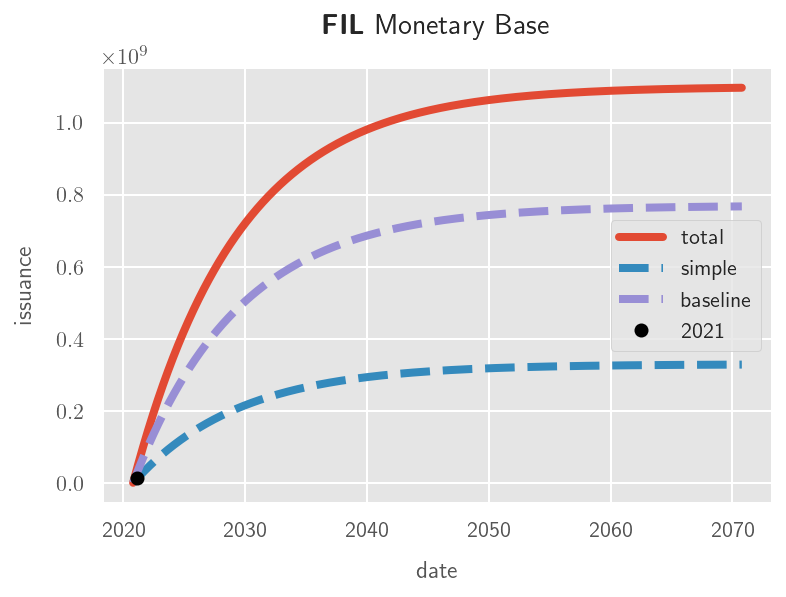

In [18]:
plot_fil_supply_curve_simple(supply)

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

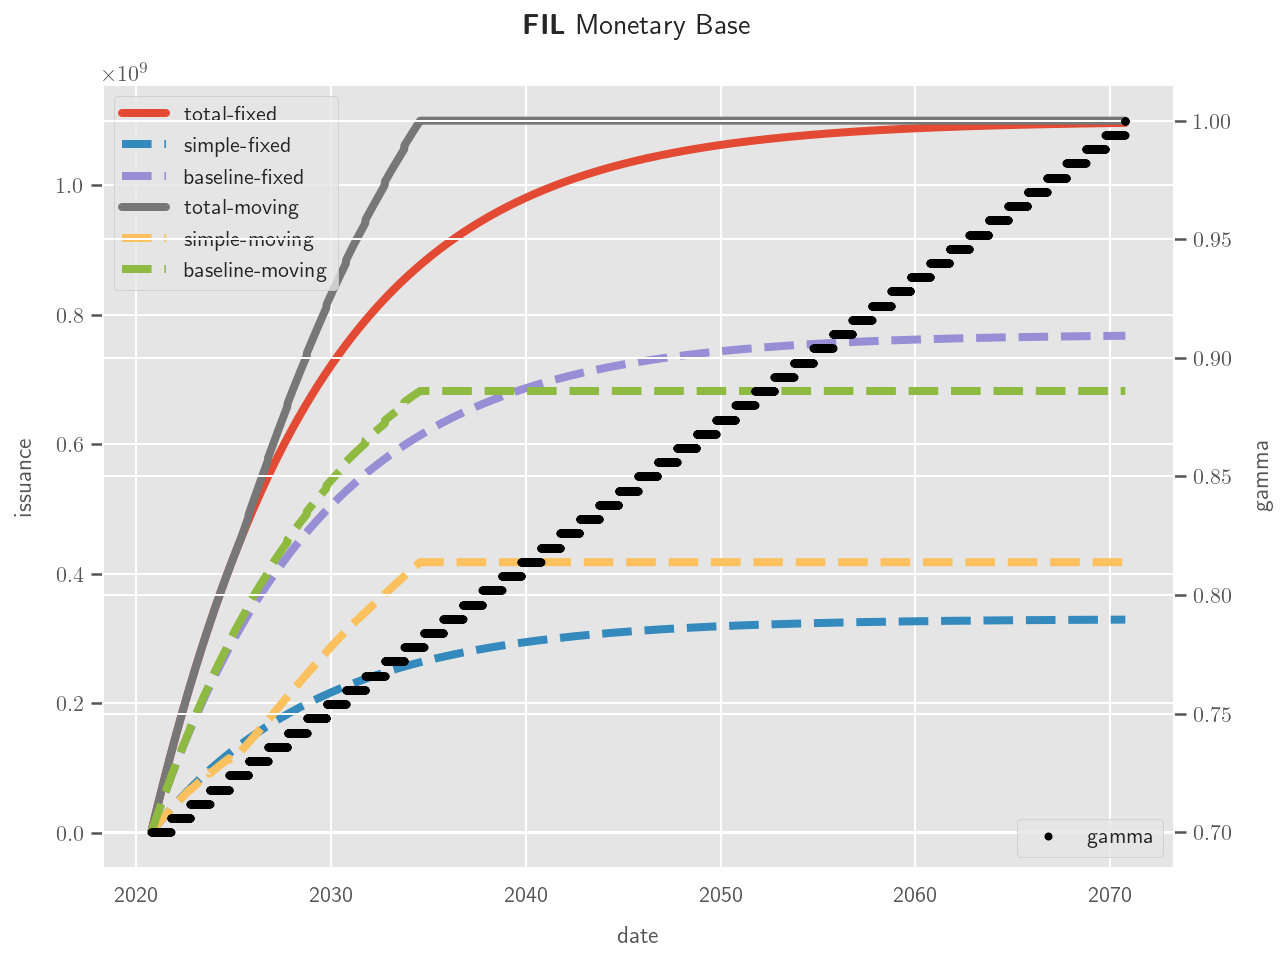

In [46]:
plot_fil_supply_curve_complex1(supply)

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

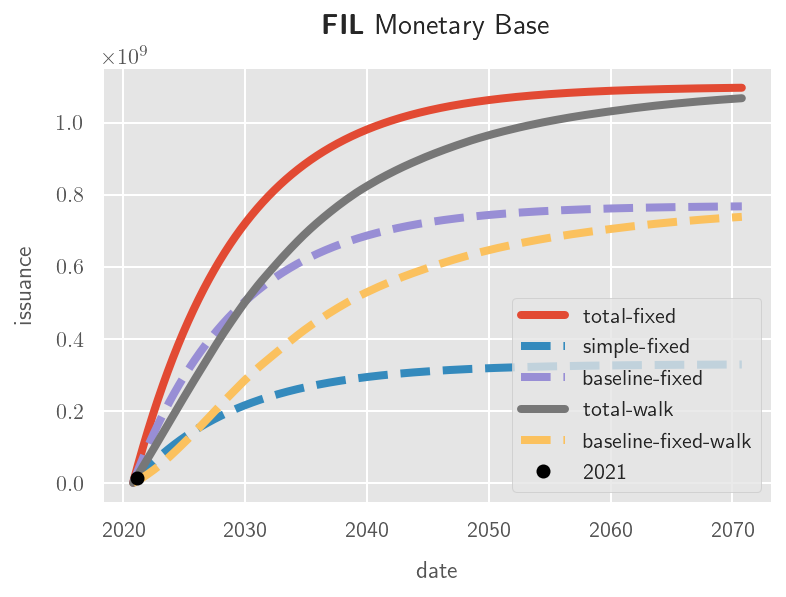

In [49]:
plot_fil_supply_curve_complex2(supply)

## Standardize Time Series

In [13]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 2609 lines to file ../output-data/FIL_weekly.csv


,coin,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
0,FIL,10001,0.7,0.000000,5.813373e+17,5.813373e+21,3.624996e+05,8.458325e+05,0.000000e+00,3.624996e+05,8.458325e+05,0.110189,0.110189,0.000000,0.086780,0.123972,2020-10-01
1,FIL,30001,0.7,4027.629670,5.852117e+17,1.750296e+22,1.086232e+06,2.534542e+06,3.407478e+05,1.086232e+06,2.534542e+06,0.330182,0.330182,0.046137,0.260035,0.371484,2020-10-01
2,FIL,50001,0.7,8066.973473,5.880990e+17,2.924767e+22,1.808376e+06,4.219545e+06,6.823351e+05,1.808376e+06,4.219545e+06,0.549691,0.549691,0.092388,0.432911,0.618452,2020-10-01
3,FIL,70001,0.7,12128.966587,5.952575e+17,4.113230e+22,2.528935e+06,5.900848e+06,1.025685e+06,2.528935e+06,5.900848e+06,0.768719,0.768719,0.138877,0.605407,0.864878,2020-11-01
4,FIL,90001,0.7,16217.605998,5.991832e+17,5.309409e+22,3.247911e+06,7.578459e+06,1.371132e+06,3.247911e+06,7.578459e+06,0.987266,0.987266,0.185651,0.777524,1.110763,2020-11-01


,coin,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
2604,FIL,52500001,0.994,2.904915e+07,3.455076e+26,9.161711e+32,3.289701e+08,7.675969e+08,7.383748e+08,4.177249e+08,6.822751e+08,99.996919,99.996919,99.975756,100.0,100.0,2070-09-01
2605,FIL,52520001,0.994,2.906062e+07,3.500556e+26,9.231501e+32,3.289724e+08,7.676022e+08,7.384147e+08,4.177249e+08,6.822751e+08,99.997606,99.997606,99.981153,100.0,100.0,2070-09-01
2606,FIL,52540001,0.994,2.907214e+07,3.521597e+26,9.301788e+32,3.289746e+08,7.676074e+08,7.384546e+08,4.177249e+08,6.822751e+08,99.998292,99.998292,99.986560,100.0,100.0,2070-09-01
2607,FIL,52560001,1.000,2.908364e+07,3.533208e+26,9.372464e+32,3.289769e+08,7.676127e+08,7.384945e+08,4.177249e+08,6.822751e+08,99.998976,99.998976,99.991957,100.0,100.0,2070-09-01
2608,FIL,52580001,1.000,2.909509e+07,3.559594e+26,9.443460e+32,3.289791e+08,7.676179e+08,7.385341e+08,4.177249e+08,6.822751e+08,99.999659,99.999659,99.997319,100.0,100.0,2070-10-01


In [14]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 601 lines to file ../output-data/FIL_monthly.csv


,coin,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
0,FIL,10001,0.7,0.000000,5.813373e+17,5.813373e+21,3.624996e+05,8.458325e+05,0.000000e+00,3.624996e+05,8.458325e+05,0.110189,0.110189,0.000000,0.086780,0.123972,2020-10-01
1,FIL,60001,0.7,10090.550405,5.932056e+17,3.517973e+22,2.168853e+06,5.060658e+06,8.534020e+05,2.168853e+06,5.060658e+06,0.659266,0.659266,0.115550,0.519206,0.741733,2020-11-01
2,FIL,150001,0.7,28563.742219,6.080292e+17,8.937976e+22,5.395383e+06,1.258923e+07,2.413311e+06,5.395383e+06,1.258923e+07,1.640032,1.640032,0.326762,1.291611,1.845183,2020-12-01
3,FIL,240001,0.7,47275.893512,6.243087e+17,1.449689e+23,8.590156e+06,2.004370e+07,3.990172e+06,8.590156e+06,2.004370e+07,2.611147,2.611147,0.540268,2.056415,2.937774,2021-01-01
4,FIL,330001,0.7,66185.019562,6.417395e+17,2.018521e+23,1.175349e+07,2.742480e+07,5.580342e+06,1.175349e+07,2.742480e+07,3.572703,3.572703,0.755577,2.813691,4.019610,2021-02-01


,coin,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
596,FIL,52220001,0.994,2.888730e+07,3.150399e+26,8.234808e+32,3.289379e+08,7.675218e+08,7.378073e+08,4.177249e+08,6.822751e+08,99.987136,99.987136,99.898913,100.0,100.0,2070-06-01
597,FIL,52300001,0.994,2.893388e+07,3.257789e+26,8.491708e+32,3.289472e+08,7.675435e+08,7.379716e+08,4.177249e+08,6.822751e+08,99.989962,99.989962,99.921165,100.0,100.0,2070-07-01
598,FIL,52390001,0.994,2.898604e+07,3.325250e+26,8.788392e+32,3.289576e+08,7.675677e+08,7.381547e+08,4.177249e+08,6.822751e+08,99.993111,99.993111,99.945954,100.0,100.0,2070-08-01
599,FIL,52480001,0.994,2.903769e+07,3.431649e+26,9.092773e+32,3.289678e+08,7.675916e+08,7.383350e+08,4.177249e+08,6.822751e+08,99.996230,99.996230,99.970360,100.0,100.0,2070-09-01
600,FIL,52570001,1.000,2.908937e+07,3.540013e+26,9.407864e+32,3.289780e+08,7.676153e+08,7.385143e+08,4.177249e+08,6.822751e+08,99.999318,99.999318,99.994641,100.0,100.0,2070-10-01


In [15]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 51 lines to file ../output-data/FIL_yearly.csv


,coin,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
0,FIL,10001,0.700,0.000000e+00,5.813373e+17,5.813373e+21,3.624996e+05,8.458325e+05,0.000000e+00,3.624996e+05,8.458325e+05,0.110189,0.110189,0.000000,0.086780,0.123972,2020-10-01
1,FIL,240001,0.700,4.727589e+04,6.243087e+17,1.449689e+23,8.590156e+06,2.004370e+07,3.990172e+06,8.590156e+06,2.004370e+07,2.611147,2.611147,0.540268,2.056415,2.937774,2021-01-01
2,FIL,1290001,0.706,3.014630e+05,9.717685e+17,9.732012e+23,4.361862e+07,1.017768e+08,2.509223e+07,4.274624e+07,1.026491e+08,13.258735,13.258735,3.397482,10.233109,15.045125,2022-01-01
3,FIL,2340001,0.712,6.170875e+05,1.432376e+18,2.214343e+24,7.482954e+07,1.746023e+08,5.048744e+07,7.183636e+07,1.775955e+08,22.745909,22.745909,6.835986,17.197051,26.029889,2023-01-01
4,FIL,3390001,0.718,1.000402e+06,2.210259e+18,4.114643e+24,1.026390e+08,2.394910e+08,8.016770e+07,9.648065e+07,2.456493e+08,31.199134,31.199134,10.854686,23.096696,36.004436,2024-01-01


,coin,epoch,gamma,theta,curr_power,cumsum_realized,simple_fixed,baseline_fixed,baseline_fixed_walk,simple_moving,baseline_moving,simple_fixed_pct,baseline_fixed_pct,baseline_fixed_walk_pct,simple_moving_pct,baseline_moving_pct,date
46,FIL,47580001,0.970,2.617116e+07,5.203208e+25,1.373475e+32,3.282315e+08,7.658734e+08,7.266096e+08,4.177249e+08,6.822751e+08,99.772393,99.772393,98.382748,100.0,100.0,2066-01-01
47,FIL,48630001,0.976,2.679036e+07,8.054024e+25,2.066273e+32,3.284242e+08,7.663231e+08,7.294640e+08,4.177249e+08,6.822751e+08,99.830981,99.830981,98.769239,100.0,100.0,2067-01-01
48,FIL,49680001,0.982,2.741051e+07,1.210456e+26,3.110111e+32,3.285959e+08,7.667238e+08,7.321346e+08,4.177249e+08,6.822751e+08,99.883184,99.883184,99.130839,100.0,100.0,2068-01-01
49,FIL,50730001,0.988,2.802353e+07,1.770131e+26,4.658929e+32,3.287490e+08,7.670809e+08,7.346016e+08,4.177249e+08,6.822751e+08,99.929697,99.929697,99.464864,100.0,100.0,2069-01-01
50,FIL,51780001,0.994,2.863247e+07,2.593281e+26,6.960401e+32,3.288853e+08,7.673990e+08,7.368930e+08,4.177249e+08,6.822751e+08,99.971141,99.971141,99.775115,100.0,100.0,2070-01-01
